In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import json

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from random import random
import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize
nltk.download('punkt')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
MAX_SENT_SIZE = 20

In [4]:
from src.data import COCODataset

def preprocess_text(text: str) -> list[str]:
    text = text.lower()
    return word_tokenize(text)


def filter_df(df, max_sent_size=MAX_SENT_SIZE, max_height=800, max_width=800, min_height=200, min_width=200):
    df = df[df['caption'].apply(word_tokenize).apply(len) <= MAX_SENT_SIZE-2] # <sos>, <eos>
    
    df = df[(df['height'] <= max_height) & (df['height'] >= min_height)]
    df = df[(df['width'] >= min_width) & (df['width'] <= max_width)]
        
    return df

In [5]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

image_size = (224, 224)
transforms = transforms.Compose([
    transforms.Resize((232, 232)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [6]:
train_dataset = COCODataset(
    root='/kaggle/input/coco-2017-dataset/coco2017/train2017',
    annotation_path='/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json',
    train=True,
    transform_image=transforms,
    transform_text=preprocess_text,
    filter_df=filter_df,
    take_first=100_000,
)

val_dataset = COCODataset(
    root='/kaggle/input/coco-2017-dataset/coco2017/val2017',
    annotation_path='/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json',
    train=True,
    transform_image=transforms,
    transform_text=preprocess_text,
    filter_df=filter_df,
    take_first=10_000,
)

In [7]:
len(train_dataset), len(val_dataset)

(100000, 10000)

['two', 'cars', 'parked', 'on', 'the', 'sidewalk', 'on', 'the', 'street']

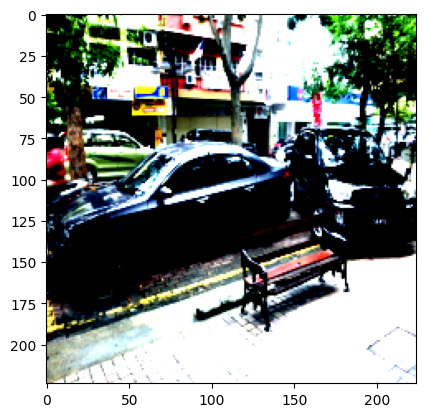

In [8]:
image, caption = train_dataset[11]
plt.imshow(image.permute(1, 2, 0))
caption

## Let's create vocab for captions

In [9]:
MAX_TOKENS = 20_000

In [10]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(df):
    for i in df.index:
        captions = df['caption'][i]
        yield word_tokenize(captions)
    
vocab = build_vocab_from_iterator(
    yield_tokens(train_dataset.df),
    min_freq=2,
    specials=['<unk>', '<pad>', '<sos>', '<eos>'],
    max_tokens=MAX_TOKENS,
)
vocab.set_default_index(0)

In [11]:
len(vocab)

9038

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
batch_size = 32

In [14]:
def collate_batch(batch):
    images = []
    captions = []
    for image, caption in batch:
        images.append(image)
        caption = ['<sos>'] + caption[:MAX_SENT_SIZE-2] + ['<eos>']
        caption = vocab.lookup_indices(caption)
        while len(caption) < MAX_SENT_SIZE:
            caption.append(vocab['<pad>'])
            
        captions.append(torch.tensor(caption))
    
    images = torch.stack(images, dim=0).to(device)
    captions = torch.stack(captions, dim=0).to(device)
    # images.shape: [batch_size, num_channels, height, width]
    # captions.shape: [batch_size, max_sent_size]
    
    return images, captions

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [15]:
for images, captions in train_dataloader:
    print("images.shape:", images.shape)
    print("captions.shape:", captions.shape)
    break

images.shape: torch.Size([32, 3, 224, 224])
captions.shape: torch.Size([32, 20])


In [20]:
from src.models.seq2seq.decoder import Decoder
from src.models.seq2seq.encoder import Encoder
from src.models.seq2seq import Seq2Seq

from src.models.train_model import train

In [21]:
# model parameters
input_channels = 3
output_dim = len(vocab)
dropout = 0.3
embed_dim = 256
hidden_dim = 512
num_layers = 2
padding_idx = vocab['<pad>']

In [22]:
encoder = Encoder(
    input_channels,
    hidden_dim,
    dropout,
).to(device)

decoder = Decoder(
    output_dim,
    embed_dim,
    hidden_dim,
    vocab,
    dropout,
    padding_idx,
).to(device)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [23]:
best_so_far = float('inf')
model = Seq2Seq(encoder, decoder, MAX_SENT_SIZE, device).to(device)

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(ignore_index=padding_idx)

In [25]:
best_so_far = train(
    model=model,
    epochs=5,
    dataloaders=(train_dataloader, val_dataloader),
    loss_fn=loss_fn,
    optimizer=optimizer,
    grad_clip=1,
    best_so_far=best_so_far,
)

Validation: 5: 100%|██████████| 313/313 [01:34<00:00,  3.31it/s, loss=3.65]


In [26]:
model.encoder.unfreeze()

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [28]:
best_so_far = train(
    model=model,
    epochs=15,
    dataloaders=(train_dataloader, val_dataloader),
    loss_fn=loss_fn,
    optimizer=optimizer,
    grad_clip=1,
    best_so_far=best_so_far,
)

Validation: 15: 100%|██████████| 313/313 [01:46<00:00,  2.93it/s, loss=3.63]


In [29]:
model.load_state_dict('best.pt')

In [30]:
def predict(model, image, transform_image):
    model.eval()
    image = transform_image(image).to(device).unsqueeze(0)
    with torch.no_grad():
        enc_outputs = model.encoder(image)
    vocab = model.decoder.vocab
    res = [vocab['<sos>']]
    hidden = enc_outputs.unsqueeze(0)
    eos_idx = vocab['<eos>']
    with torch.no_grad():
        for t in range(model.max_sent_size):
            dec_input = torch.LongTensor([res[-1]]).to(device).unsqueeze(0)

            preds, hidden = model.decoder(dec_input, hidden)

            top1 = preds.argmax(-1)

            if top1 == eos_idx:
                break
            res.append(top1.cpu().detach().numpy()[0])
    
    res = vocab.lookup_tokens(res[1:])
    
    return res

Upd: above function, was added as a method to the model (Seq2Seq class)

## Let's see the results

['a', 'giraffe', 'standing', 'in', 'a', 'a', 'tree', 'a', '.', '.']

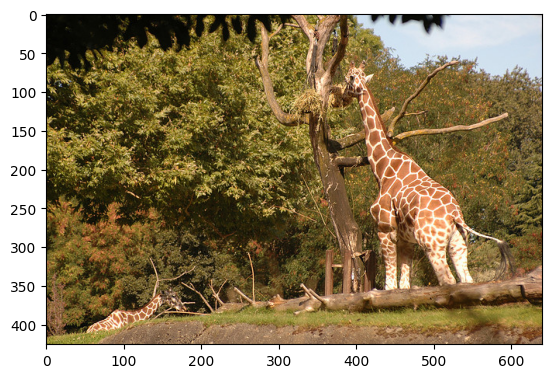

In [54]:
img = Image.open('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000025.jpg').convert('RGB')

plt.imshow(img)
predict(model, img, transforms)

['a', 'dog', 'is', 'on', 'a', 'bike', 'next', 'a', 'sidewalk']

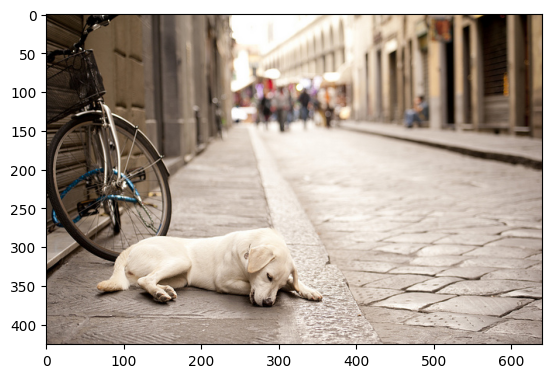

In [63]:
img = Image.open('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000074.jpg').convert('RGB')

plt.imshow(img)
predict(model, img, transforms)

['a', 'crowd', 'of', 'people', 'beach', 'a', 'and', 'umbrellas', 'a']

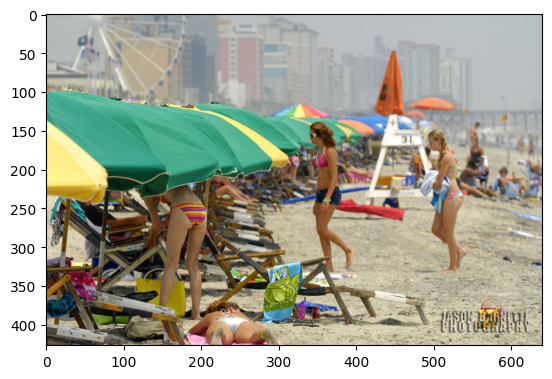

In [68]:
img = Image.open('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000315.jpg').convert('RGB')

plt.imshow(img)
predict(model, img, transforms)

['a', 'person', 'is', 'a', 'a', 'a', 'a', 'a', 'mountain']

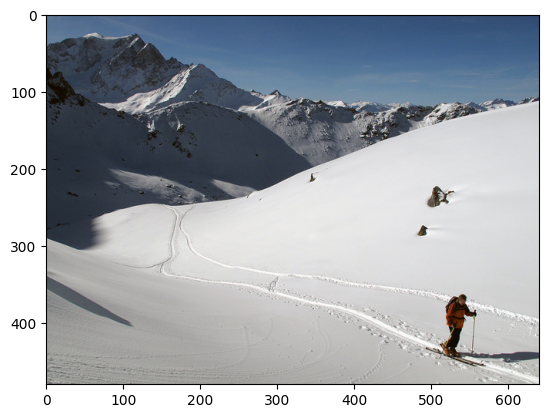

In [81]:
img = Image.open('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000000382.jpg').convert('RGB')

plt.imshow(img)
predict(model, img, transforms)

# Results:
## As we can see from examples above, for now model is not able to perfectly describe the image that it receives
## At least, for such a small model, it was capable to identify main object that are in picture, that is very good